<div style="font-weight: bold; color:#5D8AA8" align="center">
    <div style="font-size: xx-large">Machine Learning</div><br>
    <div style="font-size: x-large; color:gray">Practical Assignment: Supervised Learning</div><br>
    <div style="font-size: large">Teacher: Carlos María Alaíz Gudín - Universidad Autónoma de Madrid</div><br></div><hr>
</div>

<div style="font-size: large; font-weight: bold; margin-left: 6em;">
    <p>Names: <u>Sergio Muñoz González y Alicia Peñaranda Navazo</u>
    <p>Team Number: <u>05</u>
</div>

**Initial Configuration**

This cell defines the configuration of Jupyter Notebooks.

In [1]:
%%html
<style>
    .qst {background-color: #b1cee3; padding:10px; border-radius: 5px; border: solid 2px #5D8AA8;}
    .qst:before {font-weight: bold; content:"Exercise"; display: block; margin: 0px 10px 10px 10px;}
    h1, h2, h3 {color: #5D8AA8;}
    .text_cell_render p {text-align: justify; text-justify: inter-word;}
</style>

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

This cell imports the packages to be used (all of them quite standard except for `Utils`, which is provided with the notebook.

Importados por mi

In [3]:
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.feature_selection import SelectKBest, SelectFromModel
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

Importados por profesor

In [4]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, balanced_accuracy_score

########################################
# Any other needed package can be imported here:
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, lars_path, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
########################################

from Utils import plot_dataset_clas, evaluate_linear_model, evaluate_nonlinear_model

matplotlib.rc('figure', figsize=(15, 5))
seed = 123

import time

# Preliminaries

## Introduction

This practical assignment is designed as a **Kaggle competition**.
Specifically, a **multiclass classification** dataset will be used, so that each team will compete to improve their predictions over an unlabeled partition of the dataset.

## Objectives

The following aspects will be taken into account when evaluating the assignment.


* Analyse the data.


* Preprocess the features automatically using *pipelines*.


* Adjust the hyper-parameters with a validation stage.


* Try different models to improve the performance, at least:
    * (Regularized) Logistic Regression.
    * SVC.
    * ANNs.


* Submit the prediction at least once per week (the evolution of the performance will be also considered).


* Any other approach that may improve either the performance or interpretability of the model (e.g. feature selection, ensembles...).


* Analyse the results obtained after each experiment, and make decisions following the conclusions.

### Team Number

The **number of the team** should be inserted here, so that the file of predictions has the appropriate name.

In [5]:
########################################
# The team number should be inserted here:
team_number = 5
########################################

### Evaluation of the Model

The following function evaluates a muliclass model, computing and showing the accuracy and balanced accuracy over both the training and test partitions.

In [6]:
def evaluate_model(model, X_tr, y_tr, X_te, y_te, print_table=True):
    y_tr_p = model.predict(X_tr)
    y_te_p = model.predict(X_te)

    er_tr = [accuracy_score(y_tr, y_tr_p), balanced_accuracy_score(y_tr, y_tr_p)]
    er_te = [accuracy_score(y_te, y_te_p), balanced_accuracy_score(y_te, y_te_p)]

    ers = [er_tr, er_te]
    headers=["Acc", "Bal. Acc"]

    if print_table:
        print("%10s" % "", end="")
        for h in headers:
            print("%10s" % h, end="")
        print("")

        headersc = ["Train", "Test"]

        cnt = 0
        for er in ers:
            hc = headersc[cnt]
            cnt = cnt + 1
            print("%10s" % hc, end="")

            for e in er:
                print("%10.2f" % e, end="")
            print("")

    return ers

## Submission of the Predictions

The following function saves the predictions on the **challenge partition** to a file with syntax `Team_TT_YYYYMMDD-HHMMSS.pred`, where `TT` stands for the team number, and `YYYYMMDD-HHMMSS` is a timestamp to distinguish the different submissions of a team.

In [7]:
def save_predictions(y_ch_p, n_preds=500):
    if (len(y_ch_p) != n_preds):
        print("Error saving the predictions, it should be a vector of %d lables" % n_preds)
    else:
        time_str = time.strftime("%Y%m%d-%H%M%S")
        np.savetxt("Team_%02d_%s.txt" % (team_number, time_str), y_ch_p, fmt="%d")

Once the prediction file has been generated, it can be download to Moodle in the following [link](https://posgrado.uam.es/mod/assign/view.php?id=727118)

# Dataset

A real dataset will be tackled in this practical assignment.
In particular, the [fetal health](https://www.kaggle.com/andrewmvd/fetal-health-classification) dataset of Kaggle, that aims to classify the fetal health in three classes:
1. Normal.
2. Suspect.
3. Pathological.

The input data are a set of $21$ variables extracted from the cardiotocographies (CTGs).

## Load of the Dataset

This cell loads the data, in particular three partitions:
1. A training partition, given by `X_tr` and `y_tr`, to train (and validate) the models.
2. A test partition, given by `X_te` and `y_te`, to estimate the performance of the model.
3. A challenge partition, given by `X_ch`. The real labels are unknown, and hence the predictions should be submitted to know the real performance of the model.

In [8]:
rootf = "./Data/fetal_health"

X_tr = np.loadtxt(rootf + "_tr.dat")
X_te = np.loadtxt(rootf + "_te.dat")
X_ch = np.loadtxt(rootf + "_ch.dat")

y_tr = np.loadtxt(rootf + "_tr.lab")
y_te = np.loadtxt(rootf + "_te.lab")


features = [line.rstrip('\n') for line in open("./Data/fetal_health.head")]
n_features = len(features)

## Initial Incomplete Analysis

In [9]:
# number of features
print(n_features)

21


In [10]:
# number of patients
len(X_tr)

1126

In [11]:
X_df = pd.DataFrame(data=X_tr, columns=features)
X_df['y'] = y_tr
X_df.describe()

,baseline value,accelerations,fetal movement,uterine contractions,light decelerations,severe decelerations,prolongued decelerations,abnormal short term variability,mean value of short term variability,percentage of time with abnormal long term variability,...,histogram min,histogram max,histogram number of peaks,histogram number of zeroes,histogram mode,histogram mean,histogram median,histogram variance,histogram tendency,y
count,1126.000000,1126.000000,1126.000000,1126.000000,1126.000000,1126.000000,1126.000000,1126.000000,1126.000000,1126.000000,...,1126.000000,1126.000000,1126.000000,1126.000000,1126.000000,1126.000000,1126.000000,1126.000000,1126.000000,1126.000000
mean,133.515098,0.003189,0.009187,0.004289,0.001860,0.000004,0.000159,47.341030,1.311545,10.170515,...,93.847247,164.268206,4.043517,0.306394,137.595915,134.753996,138.320604,18.868561,0.333925,1.303730
std,9.952297,0.003874,0.045159,0.002998,0.002948,0.000067,0.000617,16.995138,0.867953,18.825969,...,29.959999,18.210546,2.906677,0.694930,16.866934,15.869380,14.671674,30.135259,0.608418,0.614003
min,106.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.200000,0.000000,...,50.000000,122.000000,0.000000,0.000000,60.000000,75.000000,77.000000,0.000000,-1.000000,1.000000
25%,126.250000,0.000000,0.000000,0.002000,0.000000,0.000000,0.000000,33.000000,0.700000,0.000000,...,66.000000,152.000000,2.000000,0.000000,129.000000,125.000000,129.000000,2.000000,0.000000,1.000000
50%,133.000000,0.002000,0.000000,0.004000,0.000000,0.000000,0.000000,50.000000,1.100000,0.000000,...,94.000000,163.000000,3.000000,0.000000,139.000000,136.000000,139.000000,7.000000,0.000000,1.000000
75%,141.000000,0.005000,0.003000,0.006000,0.003000,0.000000,0.000000,61.000000,1.700000,11.750000,...,120.000000,175.000000,6.000000,0.000000,148.000000,146.000000,149.000000,23.750000,1.000000,1.000000
max,160.000000,0.019000,0.477000,0.015000,0.015000,0.001000,0.005000,86.000000,7.000000,91.000000,...,159.000000,238.000000,16.000000,10.000000,187.000000,182.000000,186.000000,269.000000,1.000000,3.000000


Plot of the data over the first two features.

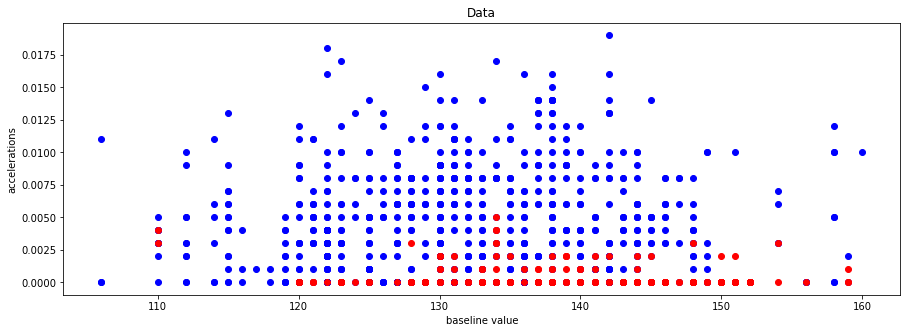

In [12]:
plot_dataset_clas(X_tr, y_tr)
plt.xlabel(features[0])
plt.ylabel(features[1])
plt.axis("auto")
plt.show()

Balance of the dataset.

In [13]:
for lab in np.unique(y_tr):
    n_sam = np.sum(y_tr == lab)
    print("Class %d: %3d samples (%5.2f%%)" % (lab, n_sam, 100.0 * n_sam / len(y_tr)))

Class 1: 877 samples (77.89%)
Class 2: 156 samples (13.85%)
Class 3:  93 samples ( 8.26%)


In [14]:
# Analyse statically insight of data

X_df = pd.DataFrame(data=X_tr, columns=features)
X_df['y'] = y_tr
X_df.describe().T

,count,mean,std,min,25%,50%,75%,max
baseline value,1126.0,133.515098,9.952297,106.0,126.250,133.000,141.000,160.000
accelerations,1126.0,0.003189,0.003874,0.0,0.000,0.002,0.005,0.019
fetal movement,1126.0,0.009187,0.045159,0.0,0.000,0.000,0.003,0.477
uterine contractions,1126.0,0.004289,0.002998,0.0,0.002,0.004,0.006,0.015
light decelerations,1126.0,0.001860,0.002948,0.0,0.000,0.000,0.003,0.015
severe decelerations,1126.0,0.000004,0.000067,0.0,0.000,0.000,0.000,0.001
prolongued decelerations,1126.0,0.000159,0.000617,0.0,0.000,0.000,0.000,0.005
abnormal short term variability,1126.0,47.341030,16.995138,12.0,33.000,50.000,61.000,86.000
mean value of short term variability,1126.0,1.311545,0.867953,0.2,0.700,1.100,1.700,7.000
percentage of time with abnormal long term variability,1126.0,10.170515,18.825969,0.0,0.000,0.000,11.750,91.000


In [15]:
X_df.isnull().sum()

# there's no null values in our data

baseline value                                            0
accelerations                                             0
fetal movement                                            0
uterine contractions                                      0
light decelerations                                       0
severe decelerations                                      0
prolongued decelerations                                  0
abnormal short term variability                           0
mean value of short term variability                      0
percentage of time with abnormal long term variability    0
mean value of long term variability                       0
histogram width                                           0
histogram min                                             0
histogram max                                             0
histogram number of peaks                                 0
histogram number of zeroes                                0
histogram mode                          

In [16]:
numeric_X_df = X_df.select_dtypes(exclude="object")
numeric_corr = numeric_X_df.corr()

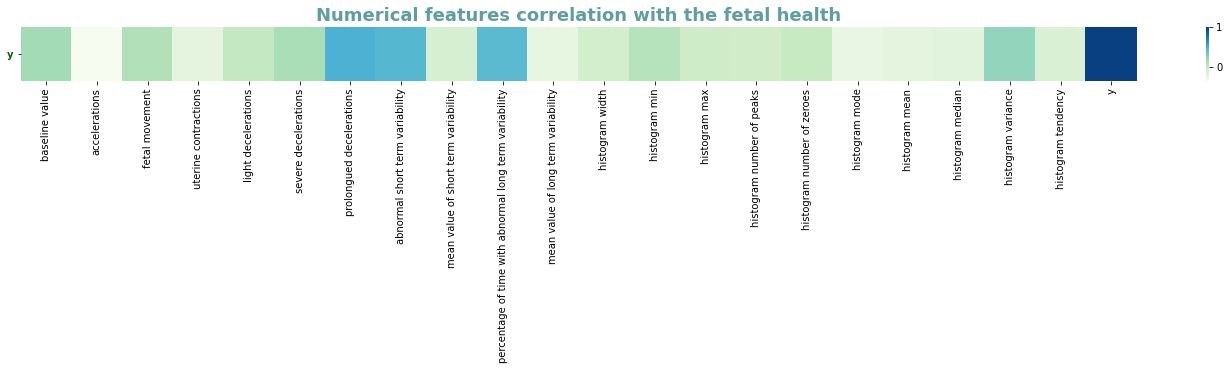

In [17]:
f,ax=plt.subplots(figsize=(25,1))
sns.heatmap(numeric_corr.sort_values(by=["y"], ascending=False).head(1), cmap="GnBu")
plt.title("Numerical features correlation with the fetal health", weight="bold", fontsize=18, color="#5F9EA0")
plt.yticks(weight="bold", color="darkgreen", rotation=0)

plt.show()

In [18]:
Num_feature = numeric_corr["y"].sort_values(ascending=False).head(20).to_frame()

cm = sns.light_palette("#5F9EA0", as_cmap=True)

style = Num_feature.style.background_gradient(cmap=cm)
style

,y
y,1.000000
prolongued decelerations,0.496407
abnormal short term variability,0.460189
percentage of time with abnormal long term variability,0.440068
histogram variance,0.235009
baseline value,0.170314
severe decelerations,0.141059
fetal movement,0.110212
histogram min,0.078920
light decelerations,0.019148


Basandonos en estos gráficos, podemos decir que "prolongued decelerations", "abnormal short term variability", "percentage of time with abnormal long term variability" son las características con mayor correlación con la salud fetal.

# Experiments

## Experiment 1:Lasso

In [47]:
pipeline = Pipeline([('scaler',StandardScaler()),('lasso',Lasso())])
grid_param = [{"lasso": [Lasso()],"lasso__normalize" : [True, False],
               "lasso__selection" : ["cyclic","random"],
               "lasso__alpha": np.linspace(1, 100,) }]
gridcv = GridSearchCV(pipeline, grid_param, cv=5,n_jobs=-1) 
result =gridcv.fit(X_tr,y_tr)

print(result.best_params_)

{'lasso': Lasso(normalize=True), 'lasso__alpha': 1.0, 'lasso__normalize': True, 'lasso__selection': 'cyclic'}


## Experiment 2: Nearest Neighbor algorithm

* En el primer ejemplo hemos realizado una clasificación con KNN , realizando una escalado previo de los datos y feature selection por ANOVA(F_classif), de manera externa al pipelines. El número de features seleccionadas se ha hecho teniendo en cuenta la correlación de éstas con la salud fetal.

In [33]:
# Data standarization
scaler = preprocessing.StandardScaler().fit(X_tr)
X_train_scaled = scaler.transform(X_tr)
X_test_scaled = scaler.transform(X_te)
X_ch_scaled = scaler.transform(X_ch)

# We create a filter to select the required number of features
# The filter will be based on the F-statistc "f_classif".

filtering = SelectKBest(f_classif, k=10)
filtering.fit(X_train_scaled, y_tr)

# Carrying out the feature selection 
X_train_sel = filtering.transform(X_train_scaled)
X_test_sel = filtering.transform(X_test_scaled)

X_ch_sel = filtering.transform(X_ch_scaled)
pipeline = Pipeline([ ('knn', KNeighborsClassifier()) ]) # defining the pipline

N_neighbors = [1, 3, 5, 7, 11, 15, 20, 25, 30]
param_grid = { 'knn__n_neighbors': N_neighbors } 

skfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=0) # evaluating the performance for each value of the hyperparameters
gridcv = GridSearchCV(pipeline, cv=skfold, n_jobs=1, param_grid=param_grid, \
    scoring=make_scorer(accuracy_score))
result = gridcv.fit(X_train_sel, y_tr)
#En vez de pasar directamente el gridccv a la función de evaluacion del movelos, al estar validando solamente un hiperparametro, lo extraemos de los resultados del modelo
#Y entrenamos el modelo aparte,parandole ese mejor hiperparametro, los resultados como es de esperar dan igual que pasando directamente el gridcv ajustados al evaluador de modelos
accuracies = gridcv.cv_results_['mean_test_score']
std_accuracies = gridcv.cv_results_['std_test_score']

best_k_neigh = N_neighbors[ np.argmax(accuracies) ]    

# Fitting the final model and estimating its performance
knn = KNeighborsClassifier(n_neighbors = best_k_neigh)
knn.fit(X_train_sel, y_tr)
y_pred = knn.predict(X_test_sel)

evaluate_model(knn, X_train_sel, y_tr, X_test_sel, y_te, print_table=True)
print(np.mean(accuracies))
print(result.best_params_)

                 Acc  Bal. Acc
     Train      0.95      0.90
      Test      0.91      0.80
0.899214250596994
{'knn__n_neighbors': 3}


In [15]:
# Prediction for challenge partitions
y_ch_p = knn.predict(X_ch_sel)
save_predictions(y_ch_p, n_preds=500)

* En este este segundo ejemplo incluimos el StandardScaler y el feature selection por F_classif junto con el clasificador KNN en el pipeline. Como vemos esto nos ahorra tener que realizar varios ajustes y transformaciones de los pasos manualmente y se realizará de manera secuencial e interna en el grid gracias al pipeline.

In [30]:
# Choosing values for the number of neighbors (Hyperparameter)
pipeline = Pipeline([('scaler',StandardScaler()),('f_classif',SelectKBest(f_classif, k=10)),('knn', KNeighborsClassifier()) ]) # defining the pipline

N_neighbors = [1, 3, 5, 7, 11, 15, 20, 25, 30]
param_grid = { 'knn__n_neighbors': N_neighbors } 

skfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=0) # evaluating the performance for each value of the hyperparameters
gridcv = GridSearchCV(pipeline, cv=skfold, n_jobs=1, param_grid=param_grid, \
    scoring=make_scorer(accuracy_score))
result = gridcv.fit(X_tr, y_tr)
 
# Fitting the final model and estimating its performance
evaluate_model(gridcv, X_tr, y_tr, X_te, y_te, print_table=True)
print(np.mean(accuracies))
print(result.best_params_)

                 Acc  Bal. Acc
     Train      0.95      0.90
      Test      0.91      0.80
nan
{'knn__n_neighbors': 3}


Como observamos nos dan los mismos resultados ahorrándonos bastante código. Esto es por éste potencial por el cual hemos utilizado mucho los pipelines a lo largo del código

* Tambien hemos comprobado que al realizar KNN sin el filtro f_classif, tanto la Accuracy como la Balanced Acuraccy nos muestran peores resultados

In [34]:

# Choosing values for the number of neighbors (Hyperparameter)
pipeline = Pipeline([('scaler',StandardScaler()),('knn', KNeighborsClassifier()) ]) # defining the pipline

N_neighbors = [1, 3, 5, 7, 11, 15, 20, 25, 30]
param_grid = { 'knn__n_neighbors': N_neighbors } 

skfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=0) # evaluating the performance for each value of the hyperparameters
gridcv = GridSearchCV(pipeline, cv=skfold, n_jobs=1, param_grid=param_grid, \
    scoring=make_scorer(accuracy_score))
result = gridcv.fit(X_tr, y_tr)
   
# Fitting the final model and estimating its performance
evaluate_model(gridcv, X_tr, y_tr, X_te, y_te, print_table=True)
print(np.mean(accuracies))
print(result.best_params_)

                 Acc  Bal. Acc
     Train      0.91      0.78
      Test      0.87      0.70
0.899214250596994
{'knn__n_neighbors': 11}


## Experiment 3: Logistic Regression

* Inicialmente hemos utilizado el clasificador de regresión logística sin llevar a cabo un filtrado de features.

In [36]:
# Choosen the values for the penalty (hyperparameter)

pipeline = Pipeline([ ('scaler',StandardScaler()),('log_reg', LogisticRegression()) ])

param_grid = {
    'log_reg__penalty':['l1', 'l2', 'elasticnet', 'none'],
   # 'dual'=False,
   # 'tol'=0.0001,
    'log_reg__C':[0.5, 1.0, 2.0],
   # 'fit_intercept'=True,
   # 'intercept_scaling'=1,
    'log_reg__class_weight':({1:1, 2:1.3, 3:2}, {1:1, 2:1.5, 3:2.5}, {1:0.5, 2:2, 3:3}, {1:0.5, 2:1.5, 3:4}),
   # 'random_state'=None,
    'log_reg__solver':['lbfgs', 'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
   # 'max_iter': [400, 300]
   # 'multi_class'='auto',
   # 'verbose'=0,
   # 'warm_start'=False,
   # 'n_jobs'=None,
    #'l1_ratio'=None,
}

skfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=0) # evaluating the performance for each value of the hyperparameters
gridcv = GridSearchCV(pipeline, cv=skfold, n_jobs=1, param_grid=param_grid, \
    scoring=make_scorer(accuracy_score),verbose = 1)
result = gridcv.fit(X_tr, y_tr)

accuracies = gridcv.cv_results_['mean_test_score']
std_accuracies = gridcv.cv_results_['std_test_score']


evaluate_model(gridcv, X_tr, y_tr, X_te, y_te, print_table=True)
print(np.mean(accuracies))
print(result.best_params_)

Fitting 10 folds for each of 288 candidates, totalling 2880 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


                 Acc  Bal. Acc
     Train      0.91      0.81
      Test      0.90      0.79
nan
{'log_reg__C': 0.5, 'log_reg__class_weight': {1: 1, 2: 1.3, 3: 2}, 'log_reg__penalty': 'l2', 'log_reg__solver': 'liblinear'}


[Parallel(n_jobs=1)]: Done 2880 out of 2880 | elapsed:   58.9s finished


In [37]:
# Prediction for challenge partitions
y_ch_p = result.predict(X_ch)
save_predictions(y_ch_p, n_preds=500)

El penalty utilizado es l2, por lo que no se lleva a cabo ninguna feature selection. En las celdas la hermos realizado aparte para ver si se aumenta la accuracy.

* Logistic regression con Feature Selection

In [38]:

# Choosen the values for the penalty (hyperparameter)

pipeline = Pipeline([('scaler',StandardScaler()),('f_classif',SelectKBest(f_classif, k=10)),('log_reg', LogisticRegression())])


param_grid= {
    'log_reg__penalty':['l1', 'l2', 'elasticnet', 'none'],
   # 'dual'=False,
   # 'tol'=0.0001,
    'log_reg__C':[0.5, 1.0, 2.0],
   # 'fit_intercept'=True,
   # 'intercept_scaling'=1,
    'log_reg__class_weight':({1:1, 2:1.3, 3:2}, {1:1, 2:1.5, 3:2.5}, {1:0.5, 2:2, 3:3}, {1:0.5, 2:1.5, 3:4}),
   # 'random_state'=None,
    'log_reg__solver':['lbfgs', 'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
   # 'max_iter': [400, 300]
   # 'multi_class'='auto',
   # 'verbose'=0,
   # 'warm_start'=False,
   # 'n_jobs'=None,
    #'l1_ratio'=None,
}
model = LogisticRegression()

skfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=0) # evaluating the performance for each value of the hyperparameters
gridcv_gbm = GridSearchCV(pipeline, param_grid=param_grid, cv=skfold, n_jobs=-1, \
    scoring=make_scorer(balanced_accuracy_score), verbose=2)
result=gridcv_gbm.fit(X_tr, y_tr)

accuracies = gridcv_gbm.cv_results_['mean_test_score']

evaluate_model(gridcv_gbm, X_tr, y_tr, X_te, y_te, print_table=True )
print(np.mean(accuracies))
print(result.best_params_)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 10 folds for each of 288 candidates, totalling 2880 fits


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 360 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 2735 tasks      | elapsed:    7.5s


                 Acc  Bal. Acc
     Train      0.88      0.85
      Test      0.87      0.83
nan
{'log_reg__C': 0.5, 'log_reg__class_weight': {1: 0.5, 2: 2, 3: 3}, 'log_reg__penalty': 'l2', 'log_reg__solver': 'lbfgs'}


[Parallel(n_jobs=-1)]: Done 2857 out of 2880 | elapsed:    7.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 2880 out of 2880 | elapsed:    7.8s finished


In [25]:
# Prediction for challenge partitions
y_ch_p = result.predict(X_ch)
save_predictions(y_ch_p, n_preds=500)

Al realizar la feature selection la balanced accuracy ha aumentado, sugiriéndonos que al eliminar estas features hemos eliminado ruido.

Es destacable que la class weight elegida da un valor mucho más alto a la tercera feature que a la primera.  En cuanto al valor de C, valores bajos aumentan la rigidez del modelo. Esto influye en que la Balance Accuracy del train dataset se aleje del 1.00.  



## Experiment 4: Support Vector Classifier

* SVC sin feature selection

In [31]:
from sklearn.svm import SVC

pipeline = Pipeline([('scaler',StandardScaler()),('SVC',SVC())])
parameter_space_SVC = {
    'SVC__C':[0.5, 0.7, 1.0, 2.0, 3.0, 4.0, 5.0],
    'SVC__kernel':['linear', 'poly', 'rbf', 'sigmoid'],
    #'degree'=3,
    'SVC__gamma':[0.001, 0.01, 0.05, 0.1, 0.5, 1],
    #'coef0'=0.0,
    #'shrinking'=True,
    #'probability'=False,
    #'tol'=0.001,
    #'cache_size'=200,
    'SVC__class_weight':({1:1, 2:1.3, 3:2}, {1:1, 2:1.5, 3:2.5}, {1:0.5, 2:2, 3:3}, {1:0.5, 2:1.5, 3:4}),
    #'verbose'=False,
    #'max_iter'=-1,
    'SVC__decision_function_shape': ['ovo', 'ovr'],
    #'break_ties': [True, False]
    #'random_state'=None,
}


skfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=0) # evaluating the performance for each value of the hyperparameters
gridcv_gbm = GridSearchCV(pipeline, parameter_space_SVC, cv=skfold, n_jobs=-1, \
    scoring=make_scorer(balanced_accuracy_score), verbose=1)
result = gridcv_gbm.fit(X_tr, y_tr)

accuracies = gridcv_gbm.cv_results_['mean_test_score']
print(np.mean(accuracies))
evaluate_model(gridcv_gbm, X_tr, y_tr, X_te, y_te, print_table=True )
print(gridcv_gbm.best_params_)

Fitting 5 folds for each of 1344 candidates, totalling 6720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 5640 tasks      | elapsed:   13.6s


0.7001363662956057
                 Acc  Bal. Acc
     Train      0.90      0.89
      Test      0.88      0.86
{'SVC__C': 2.0, 'SVC__class_weight': {1: 0.5, 2: 2, 3: 3}, 'SVC__decision_function_shape': 'ovo', 'SVC__gamma': 0.01, 'SVC__kernel': 'rbf'}


[Parallel(n_jobs=-1)]: Done 6720 out of 6720 | elapsed:   16.3s finished


* SVC con F_classif feature selection

In [32]:
pipeline = Pipeline([('scaler',StandardScaler()),('f_classif',SelectKBest(f_classif, k=10)),('SVC',SVC())])
parameter_space_SVC = {
    'SVC__C':[0.5, 0.7, 1.0, 2.0, 3.0, 4.0, 5.0],
    'SVC__kernel':['linear', 'poly', 'rbf', 'sigmoid'],
    #'degree'=3,
    'SVC__gamma':[0.001, 0.01, 0.05, 0.1, 0.5, 1],
    #'coef0'=0.0,
    #'shrinking'=True,
    #'probability'=False,
    #'tol'=0.001,
    #'cache_size'=200,
    'SVC__class_weight':({1:1, 2:1.3, 3:2}, {1:1, 2:1.5, 3:2.5}, {1:0.5, 2:2, 3:3}, {1:0.5, 2:1.5, 3:4}),
    #'verbose'=False,
    #'max_iter'=-1,
    'SVC__decision_function_shape': ['ovo', 'ovr'],
    #'break_ties': [True, False]
    #'random_state'=None,
}


skfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=0) # evaluating the performance for each value of the hyperparameters
gridcv_gbm = GridSearchCV(pipeline, parameter_space_SVC, cv=skfold, n_jobs=-1, \
    scoring=make_scorer(balanced_accuracy_score), verbose=1)
result = gridcv_gbm.fit(X_tr, y_tr)

accuracies = gridcv_gbm.cv_results_['mean_test_score']
print(np.mean(accuracies))
evaluate_model(gridcv_gbm, X_tr, y_tr, X_te, y_te, print_table=True )
print(gridcv_gbm.best_params_)

Fitting 5 folds for each of 1344 candidates, totalling 6720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 5640 tasks      | elapsed:   13.5s


0.7244959147132511
                 Acc  Bal. Acc
     Train      0.92      0.94
      Test      0.89      0.86
{'SVC__C': 3.0, 'SVC__class_weight': {1: 0.5, 2: 1.5, 3: 4}, 'SVC__decision_function_shape': 'ovo', 'SVC__gamma': 0.1, 'SVC__kernel': 'rbf'}


[Parallel(n_jobs=-1)]: Done 6720 out of 6720 | elapsed:   17.4s finished


In [34]:
# Prediction for challenge partitions
y_ch_p = result.predict(X_ch)
save_predictions(y_ch_p, n_preds=500)

Este modelo trabaja con un l2 penalty por lo que puede tener sentido hacer feature selection.  

El valor de C elegido es más alto que en los anteriores, lo que puede explicar que aumente la diferencia de las balanced accuracy entre train y test. El modelo se comporta considerablemente mejor con los datos de entrenamiento ya que los "memoriza" en cierta medida  y luego no se comporta tan bien con los datos de testing como vemos en los resultados. 

En este caso la class weight elegida, da mucho más peso a la clase 3 que la anterior lo que puede explicar también el aumento de la accuracy.  

El alto valor de gamma hace que para que haya una agrupación los valores tengan que estar próximos. Esto puede aumentar el overfiting. 

* SVC linear sin feature selection

In [35]:
from sklearn.svm import LinearSVC

pipeline = Pipeline([('scaler',StandardScaler()),('LSVC',LinearSVC())])

parameter_space_SVC = {
    'LSVC__C':[0.5, 0.7, 1.0, 2.0, 3.0, 4.0, 5.0],
    'LSVC__penalty':['l1','l2'],
    'LSVC__class_weight':({1:1, 2:1.3, 3:2}, {1:1, 2:1.5, 3:2.5}, {1:0.5, 2:2, 3:3}, {1:0.5, 2:1.5, 3:4}),
    'LSVC__intercept_scaling':[0.5, 1.0, 5.0, 7.0, 10],
    'LSVC__tol': [1e-6, 1e-5, 1e-4, 1e-3]
}


skfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=0) # evaluating the performance for each value of the hyperparameters
gridcv_gbm = GridSearchCV(pipeline, parameter_space_SVC, cv=skfold, n_jobs=-1, \
    scoring=make_scorer(balanced_accuracy_score), verbose=1)
result = gridcv_gbm.fit(X_tr, y_tr)

accuracies = gridcv_gbm.cv_results_['mean_test_score']
print(np.mean(accuracies))
evaluate_model(gridcv_gbm, X_tr, y_tr, X_te, y_te, print_table=True )
print(gridcv_gbm.best_params_)

Fitting 10 folds for each of 1120 candidates, totalling 11200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1544 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 5544 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 10934 tasks      | elapsed:   34.5s


nan
                 Acc  Bal. Acc
     Train      0.90      0.84
      Test      0.89      0.80
{'LSVC__C': 1.0, 'LSVC__class_weight': {1: 0.5, 2: 2, 3: 3}, 'LSVC__intercept_scaling': 1.0, 'LSVC__penalty': 'l2', 'LSVC__tol': 0.0001}


[Parallel(n_jobs=-1)]: Done 11177 out of 11200 | elapsed:   35.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 11200 out of 11200 | elapsed:   35.3s finished


* SVC linear utilizando ANOVA para realizar feature selection

In [37]:
from sklearn.svm import LinearSVC

pipeline = Pipeline([('scaler',StandardScaler()),('f_classif',SelectKBest(f_classif, k=10)),('LSVC',LinearSVC())])

parameter_space_SVC = {
    'LSVC__C':[0.5, 0.7, 1.0, 2.0, 3.0, 4.0, 5.0],
    'LSVC__penalty':['l1','l2'],
    'LSVC__class_weight':({1:1, 2:1.3, 3:2}, {1:1, 2:1.5, 3:2.5}, {1:0.5, 2:2, 3:3}, {1:0.5, 2:1.5, 3:4}),
    'LSVC__intercept_scaling':[0.5, 1.0, 5.0, 7.0, 10],
    'LSVC__tol': [1e-6, 1e-5, 1e-4, 1e-3]
}


skfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=0) # evaluating the performance for each value of the hyperparameters
gridcv_gbm = GridSearchCV(pipeline, parameter_space_SVC, cv=skfold, n_jobs=-1, \
    scoring=make_scorer(balanced_accuracy_score), verbose=1)
result = gridcv_gbm.fit(X_tr, y_tr)

accuracies = gridcv_gbm.cv_results_['mean_test_score']
print(np.mean(accuracies))
evaluate_model(gridcv_gbm, X_tr, y_tr, X_te, y_te, print_table=True )
print(gridcv_gbm.best_params_)

Fitting 10 folds for each of 1120 candidates, totalling 11200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 5640 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 11000 tasks      | elapsed:   24.5s


nan
                 Acc  Bal. Acc
     Train      0.89      0.83
      Test      0.88      0.81
{'LSVC__C': 1.0, 'LSVC__class_weight': {1: 0.5, 2: 2, 3: 3}, 'LSVC__intercept_scaling': 10, 'LSVC__penalty': 'l2', 'LSVC__tol': 1e-06}


[Parallel(n_jobs=-1)]: Done 11200 out of 11200 | elapsed:   24.9s finished


Aunque disminuimos el overfiting bastante la balanced accuracy nos da más baja, esto puede ser porque el hiperparámetro kernel = linear ( que viene incluído por defecto en este modelo ) no es el más adecuado. Probablemente esto tenga que ver con que el tamaño de nuestro dataset no es muy amplio. 

## Experiment 5: Artificial Neural Networks

In [12]:
from sklearn.datasets import make_moons
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier

* Entrenamos el modelo MLP con unos hiperparametros elegidos, y relizamos el escalado y filtrado por f_clasiff manualmente y no en una pipeline

In [28]:
# Data standarization
scaler = preprocessing.StandardScaler().fit(X_tr)
X_train_scaled = scaler.transform(X_tr)
X_test_scaled = scaler.transform(X_te)
X_ch_scaled = scaler.transform(X_ch)

# We create a filter to select the required number of features
# The filter will be based on the F-statistc "f_classif".

filtering = SelectKBest(f_classif, k=10)
filtering.fit(X_train_scaled, y_tr)

# Carrying out the feature selection 
X_train_sel = filtering.transform(X_train_scaled)
X_test_sel = filtering.transform(X_test_scaled)
X_ch_sel = filtering.transform(X_ch_scaled)

#Fit MLPC model 
MLPC = MLPClassifier(activation='relu', alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate='constant', solver='adam')
MLPC.fit(X_train_sel, y_tr)
y_pred = MLPC.predict(X_test_sel)


evaluate_model(MLPC, X_train_sel, y_tr, X_test_sel, y_te, print_table=True)

                 Acc  Bal. Acc
     Train      0.98      0.97
      Test      0.92      0.86


[[0.9795737122557726, 0.9728622968682555], [0.922, 0.8565567627765884]]

* MLPClasiffier , sin hacer feature selection con ANOVA

In [18]:

pipeline = Pipeline([('scaler',StandardScaler()), ('MLPC', MLPClassifier() )])

model = MLPClassifier()

parameter_space = {
    'MLPC__hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'MLPC__activation': ['tanh', 'relu'],
    'MLPC__solver': ['sgd', 'adam'],
    'MLPC__alpha': [0.0001, 0.05],
    'MLPC__learning_rate': ['constant','adaptive'],
}

skfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=0) # evaluating the performance for each value of the hyperparameters
gridcv = GridSearchCV(pipeline, parameter_space, cv=skfold, n_jobs=1, \
    scoring=make_scorer(accuracy_score),verbose=1)
result = gridcv.fit(X_tr, y_tr)
accuracies = gridcv.cv_results_['mean_test_score']

evaluate_model(result, X_tr, y_tr, X_te, y_te, print_table=True )
print(np.mean(accuracies))
print(result.best_params_)

Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed:  9.1min finished


                 Acc  Bal. Acc
     Train      0.99      0.99
      Test      0.92      0.81
0.9040555533607249
{'MLPC__activation': 'tanh', 'MLPC__alpha': 0.05, 'MLPC__hidden_layer_sizes': (50, 50, 50), 'MLPC__learning_rate': 'constant', 'MLPC__solver': 'adam'}


* MLPClasiffier , con un filtro para Feature Selection con F_classif

In [19]:

pipeline = Pipeline([('scaler',StandardScaler()),('f_classif',SelectKBest(f_classif, k=10)), ('MLPC', MLPClassifier() )])

model = MLPClassifier()

parameter_space = {
    'MLPC__hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'MLPC__activation': ['tanh', 'relu'],
    'MLPC__solver': ['sgd', 'adam'],
    'MLPC__alpha': [0.0001, 0.05],
    'MLPC__learning_rate': ['constant','adaptive'],
}

skfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=0) # evaluating the performance for each value of the hyperparameters
gridcv = GridSearchCV(pipeline, parameter_space, cv=skfold, n_jobs=1, \
    scoring=make_scorer(accuracy_score),verbose=1)
result = gridcv.fit(X_tr, y_tr)
accuracies = gridcv.cv_results_['mean_test_score']

evaluate_model(result, X_tr, y_tr, X_te, y_te, print_table=True )
print(np.mean(accuracies))
print(result.best_params_)

Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed:  8.5min finished


                 Acc  Bal. Acc
     Train      0.98      0.98
      Test      0.94      0.88
0.9014629095554151
{'MLPC__activation': 'relu', 'MLPC__alpha': 0.05, 'MLPC__hidden_layer_sizes': (50, 50, 50), 'MLPC__learning_rate': 'constant', 'MLPC__solver': 'adam'}


In [21]:
# Prediction for challenge partitions
y_ch_p = result.predict(X_ch)
save_predictions(y_ch_p, n_preds=500)

Claramente la feature selection empleada disminuye mucho el ruido y mejora la accuracy del modelo.  

Podemos ver que hay cierto overfiting al tener un 10% de diferencia entre el balanced accurracy del training set y el del test set.  
A pesar de no ser una red neuronal muy compleja y que de entre los hiperparámetros posibles en las hidden layers
el mejor devuelto es aquel con una menor cantidad de neuronas, podriamos intentar reducir el numero de neuronas y ver el resultado para ver si el overfiting disminuye o aumentar el número de capas.  

Se pueden aplicar como solución al overfitting estrategias como el dropout (eliminacion aleatoria de neuronas del modelo)
y regularizacion ridge por ejemplo.

* MLP con Feature Selection en el que no se uso pipeline en el que usamos un paramgrid algo diferente a los anteriores

In [22]:
scaler = preprocessing.StandardScaler().fit(X_tr)
X_train_scaled = scaler.transform(X_tr)
X_test_scaled = scaler.transform(X_te)

X_ch_scaled = scaler.transform(X_ch)

# We create a filter to select the required number of features
# The filter will be based on the F-statistc "f_classif".

filtering = SelectKBest(f_classif, k = 10)
filtering.fit(X_train_scaled, y_tr)

# Carrying out the feature selection 
X_train_sel = filtering.transform(X_train_scaled)
X_test_sel = filtering.transform(X_test_scaled)

X_ch_sel = filtering.transform(X_ch_scaled)

# choosen the values for the hyperparameter 

model = MLPClassifier()

parameter_space_MLPC = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'max_iter':[100, 200, 300]
}

skfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=0) # evaluating the performance for each value of the hyperparameters
gridcv_gbm = GridSearchCV(model, parameter_space_MLPC, cv=skfold, n_jobs=-1, \
    scoring=make_scorer(balanced_accuracy_score), verbose=2)
result = gridcv_gbm.fit(X_train_sel, y_tr)

accuracies = gridcv_gbm.cv_results_['mean_test_score']

print(np.mean(accuracies))
evaluate_model(gridcv_gbm, X_train_sel, y_tr, X_test_sel, y_te, print_table=True )
print(result.best_params_)

Fitting 10 folds for each of 1620 candidates, totalling 16200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:   41.0s
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed:   57.8s
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 3257 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 4877 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 5808 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 6821 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 7914 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done 9089 tasks      | 

0.7420713480591353
                 Acc  Bal. Acc
     Train      0.99      0.98
      Test      0.93      0.84
{'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (100,), 'learning_rate': 'invscaling', 'max_iter': 100, 'solver': 'lbfgs'}


## Experiment 6: Random Forest Classifier

* Clasificador random forest sin feature selection

In [24]:
pipeline = Pipeline([('scaler',StandardScaler()), ('RF', RandomForestClassifier() )])

parameter_space_rf = {
    'RF__n_estimators':[120, 150],
    'RF__max_depth':[None, 9, 10, 12],
    'RF__min_samples_split':[3, 4, 5],
    'RF__min_samples_leaf':[2,3,4], 
#     min_weight_fraction_leaf=0.0,
#     max_features='auto',
#     max_leaf_nodes=None,
#     min_impurity_decrease=0.0,
#     min_impurity_split=None,
    'RF__class_weight':({1:1, 2:1.3, 3:2}, {1:1, 2:1.5, 3:2.5}),
    'RF__ccp_alpha':(0.005, 0.001, 0.0005),
    'RF__max_samples':[None, 0.7, 0.8]
}



skfold_rf = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=0) # evaluating the performance for each value of the hyperparameters

gridcv_rf = GridSearchCV(pipeline, parameter_space_rf, cv=skfold_rf, n_jobs=-1, \
    scoring=make_scorer(balanced_accuracy_score), verbose=1)

result = gridcv_rf.fit(X_tr, y_tr)

accuracies = gridcv_rf.cv_results_['mean_test_score']
print(np.mean(accuracies))
_ = evaluate_model(gridcv_rf, X_tr, y_tr, X_te, y_te, print_table=True )
print(gridcv_rf.best_params_)

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:   43.2s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:   59.0s
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 6026 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 6480 out of 6480 | elapsed:  2.6min finished


0.8221861837138951
                 Acc  Bal. Acc
     Train      0.99      0.98
      Test      0.94      0.86
{'RF__ccp_alpha': 0.0005, 'RF__class_weight': {1: 1, 2: 1.5, 3: 2.5}, 'RF__max_depth': 10, 'RF__max_samples': None, 'RF__min_samples_leaf': 2, 'RF__min_samples_split': 5, 'RF__n_estimators': 120}


* Clasificador random forest con feature selection ANOVA

In [28]:
pipeline = Pipeline([('scaler',StandardScaler()),('f_classif',SelectKBest(f_classif, k=10)), ('RF', RandomForestClassifier() )])

parameter_space_rf = {
    'RF__n_estimators':[120, 150],
    'RF__max_depth':[None, 9, 10, 12],
    'RF__min_samples_split':[3, 4, 5],
    'RF__min_samples_leaf':[2,3,4], 
#     min_weight_fraction_leaf=0.0,
#     max_features='auto',
#     max_leaf_nodes=None,
#     min_impurity_decrease=0.0,
#     min_impurity_split=None,
    'RF__class_weight':({1:1, 2:1.3, 3:2}, {1:1, 2:1.5, 3:2.5}),
    'RF__ccp_alpha':(0.005, 0.001, 0.0005),
    'RF__max_samples':[None, 0.7, 0.8]
}



skfold_rf = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=0) # evaluating the performance for each value of the hyperparameters

gridcv_rf = GridSearchCV(pipeline, parameter_space_rf, cv=skfold_rf, n_jobs=-1, \
    scoring=make_scorer(balanced_accuracy_score), verbose=1)

result = gridcv_rf.fit(X_tr, y_tr)

accuracies = gridcv_rf.cv_results_['mean_test_score']
print(np.mean(accuracies))
_ = evaluate_model(gridcv_rf, X_tr, y_tr, X_te, y_te, print_table=True )
print(gridcv_rf.best_params_)

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:   42.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:   57.0s
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 6026 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 6480 out of 6480 | elapsed:  2.5min finished


0.8431213991358393
                 Acc  Bal. Acc
     Train      0.98      0.97
      Test      0.94      0.87
{'RF__ccp_alpha': 0.001, 'RF__class_weight': {1: 1, 2: 1.5, 3: 2.5}, 'RF__max_depth': 10, 'RF__max_samples': None, 'RF__min_samples_leaf': 2, 'RF__min_samples_split': 3, 'RF__n_estimators': 150}


## Experiment 7: GBM Classifier

* GBM con feature selection F_classif

In [29]:
from sklearn.ensemble import GradientBoostingClassifier

pipeline = Pipeline([('scaler',StandardScaler()),('f_classif',SelectKBest(f_classif, k=10)), ('GBM', GradientBoostingClassifier() )])

# choosen the values for the hyperparameters 

parameter_space = {
    'GBM__n_estimators':[100, 200, 300],
    'GBM__learning_rate':[0.05, 0.1],
    'GBM__max_depth':[None, 4, 5],
    'GBM__min_samples_split':[2, 3, 4],
    'GBM__min_samples_leaf':[1,2,3], 
#     min_weight_fraction_leaf=0.0,
#     max_features='auto',
#     max_leaf_nodes=None,
#     min_impurity_decrease=0.0,
#     min_impurity_split=None,
    'GBM__ccp_alpha':(0.0, 0.0001, 0.00005),
    'GBM__subsample':(0.9, 0.8, 0.7),
}


skfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=0) # evaluating the performance for each value of the hyperparameters
gridcv_gbm = GridSearchCV(pipeline, parameter_space, cv=skfold, n_jobs=-1, \
    scoring=make_scorer(balanced_accuracy_score), verbose=1)
result = gridcv_gbm.fit(X_tr, y_tr)

accuracies = gridcv_gbm.cv_results_['mean_test_score']
print(np.mean(accuracies))
evaluate_model(gridcv_gbm, X_tr, y_tr, X_te, y_te, print_table=True )
print(gridcv_gbm.best_params_)

Fitting 5 folds for each of 1458 candidates, totalling 7290 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed: 11.3min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed: 12.6min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed: 15.0min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed: 17.5min
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed: 19.4min
[Parallel(n_jobs=-1)]: Done 6026 tasks      | elapsed: 21.9min
[Parallel(n_jobs=-1)]: Done 7176 tasks      | elapsed: 24.9min
[Parallel(n_jobs=-1)]: Done 7290 out of 7290 | elapsed: 25.1min finished


0.8733819513239154
                 Acc  Bal. Acc
     Train      1.00      1.00
      Test      0.94      0.87
{'GBM__ccp_alpha': 0.0, 'GBM__learning_rate': 0.1, 'GBM__max_depth': 4, 'GBM__min_samples_leaf': 3, 'GBM__min_samples_split': 3, 'GBM__n_estimators': 300, 'GBM__subsample': 0.7}


* GBM sin feature selection

In [30]:
from sklearn.ensemble import GradientBoostingClassifier

pipeline = Pipeline([('scaler',StandardScaler()), ('GBM', GradientBoostingClassifier() )])

# choosen the values for the hyperparameters 

parameter_space = {
    'GBM__n_estimators':[100, 200, 300],
    'GBM__learning_rate':[0.05, 0.1],
    'GBM__max_depth':[None, 4, 5],
    'GBM__min_samples_split':[2, 3, 4],
    'GBM__min_samples_leaf':[1,2,3], 
#     min_weight_fraction_leaf=0.0,
#     max_features='auto',
#     max_leaf_nodes=None,
#     min_impurity_decrease=0.0,
#     min_impurity_split=None,
    'GBM__ccp_alpha':(0.0, 0.0001, 0.00005),
    'GBM__subsample':(0.9, 0.8, 0.7),
}


skfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=0) # evaluating the performance for each value of the hyperparameters
gridcv_gbm = GridSearchCV(pipeline, parameter_space, cv=skfold, n_jobs=-1, \
    scoring=make_scorer(balanced_accuracy_score), verbose=1)
result = gridcv_gbm.fit(X_tr, y_tr)

accuracies = gridcv_gbm.cv_results_['mean_test_score']
print(np.mean(accuracies))
evaluate_model(gridcv_gbm, X_tr, y_tr, X_te, y_te, print_table=True )
print(gridcv_gbm.best_params_)

Fitting 5 folds for each of 1458 candidates, totalling 7290 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   31.2s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed: 16.7min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed: 18.5min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed: 22.7min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed: 27.1min
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed: 30.3min
[Parallel(n_jobs=-1)]: Done 6026 tasks      | elapsed: 34.7min
[Parallel(n_jobs=-1)]: Done 7176 tasks      | elapsed: 40.0min
[Parallel(n_jobs=-1)]: Done 7290 out of 7290 | elapsed: 40.4min finished


0.8742461937228856
                 Acc  Bal. Acc
     Train      1.00      1.00
      Test      0.94      0.87
{'GBM__ccp_alpha': 0.0001, 'GBM__learning_rate': 0.1, 'GBM__max_depth': 4, 'GBM__min_samples_leaf': 1, 'GBM__min_samples_split': 3, 'GBM__n_estimators': 200, 'GBM__subsample': 0.8}


Podemos apreciar que hay cierto overfitting en el modelo. Hay varias estrategias para lidiar con el overfitting que nos presenta el clasificador boost gradient machine. Una de ellas es aumentar min_samples_split y min_samples_leaf. Establecer valores más altos para estos no permitirá que el modelo memorice cómo identificar correctamente una sola pieza de datos o grupos de datos muy pequeños. Para un conjunto de datos grande (~ filas de 1 mil), colocaría estos valores en alrededor de 50, o incluso mas.  
También puede utilizar submuestra para reducir el sobreajuste y max_features. Básicamente, estos parámetros no permiten que su modelo mire algunos de los datos, lo que le impide memorizarlos.